## Very basic demo

In [1]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(
    n_series=20,
    max_length=100,
    n_static_features=1,
    static_as_categorical=False,
    with_trend=True
)

series.head()

,unique_id,ds,y,static_0
0,id_00,2000-01-01,17.519167,72
1,id_00,2000-01-02,87.799695,72
2,id_00,2000-01-03,177.442975,72
3,id_00,2000-01-04,232.704110,72
4,id_00,2000-01-05,317.510474,72


Note that the `unique_id` column is mandatory! If you are merely dealing with a single series then you fill a constant in there. 

<Axes: xlabel='ds'>

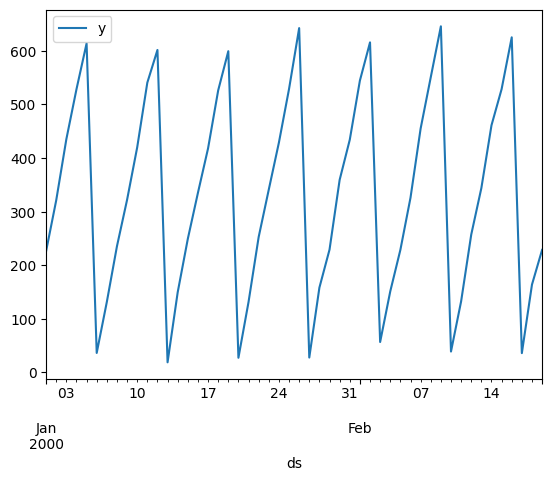

In [2]:
series.loc[lambda d: d['unique_id'] == "id_02"].plot("ds", "y")

In [3]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression


models = [
    HistGradientBoostingRegressor(),
    LinearRegression(),
]

fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=14)]
    },
    date_features=['dayofweek'],
    target_transforms=[Differences([1])],
)

In [4]:
series.shape

(1461, 4)

In [5]:
fcst.preprocess(series)

,unique_id,ds,y,static_0,lag7,lag14,expanding_mean_lag1,rolling_mean_lag7_window_size14,dayofweek
21,id_00,2000-01-22,-456.530375,72,-442.596319,-467.350310,22.831967,0.729090,5
22,id_00,2000-01-23,70.494425,72,71.833451,100.098431,0.005189,0.840013,6
23,id_00,2000-01-24,80.358734,72,81.538397,58.991559,3.209245,0.261093,0
24,id_00,2000-01-25,67.095036,72,49.639207,85.409599,6.563571,-0.140474,1
25,id_00,2000-01-26,76.114648,72,86.883838,63.227236,9.085715,0.007917,2
...,...,...,...,...,...,...,...,...,...
1456,id_19,2000-03-09,-30.071284,4,-29.834345,-28.439540,0.712994,0.386366,3
1457,id_19,2000-03-10,5.299399,4,4.921499,4.269643,0.260284,0.262087,4
1458,id_19,2000-03-11,5.037482,4,7.596848,7.351448,0.333314,0.536637,5
1459,id_19,2000-03-12,4.796646,4,5.135139,5.644122,0.400517,0.432944,6


In [6]:
fcst.fit(series)

MLForecast(models=[HistGradientBoostingRegressor, LinearRegression], freq=D, lag_features=['lag7', 'lag14', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size14'], date_features=['dayofweek'], num_threads=1)

In [7]:
predictions = fcst.predict(7 * 8)
predictions

,unique_id,ds,HistGradientBoostingRegressor,LinearRegression
0,id_00,2000-04-04,294.916439,311.620495
1,id_00,2000-04-05,364.351641,380.086626
2,id_00,2000-04-06,437.620459,467.677262
3,id_00,2000-04-07,508.789710,535.772823
4,id_00,2000-04-08,73.319649,91.942524
...,...,...,...,...
1115,id_19,2000-05-04,-24.154586,53.175747
1116,id_19,2000-05-05,-13.476879,59.266032
1117,id_19,2000-05-06,-2.935944,66.177335
1118,id_19,2000-05-07,7.491566,71.893499


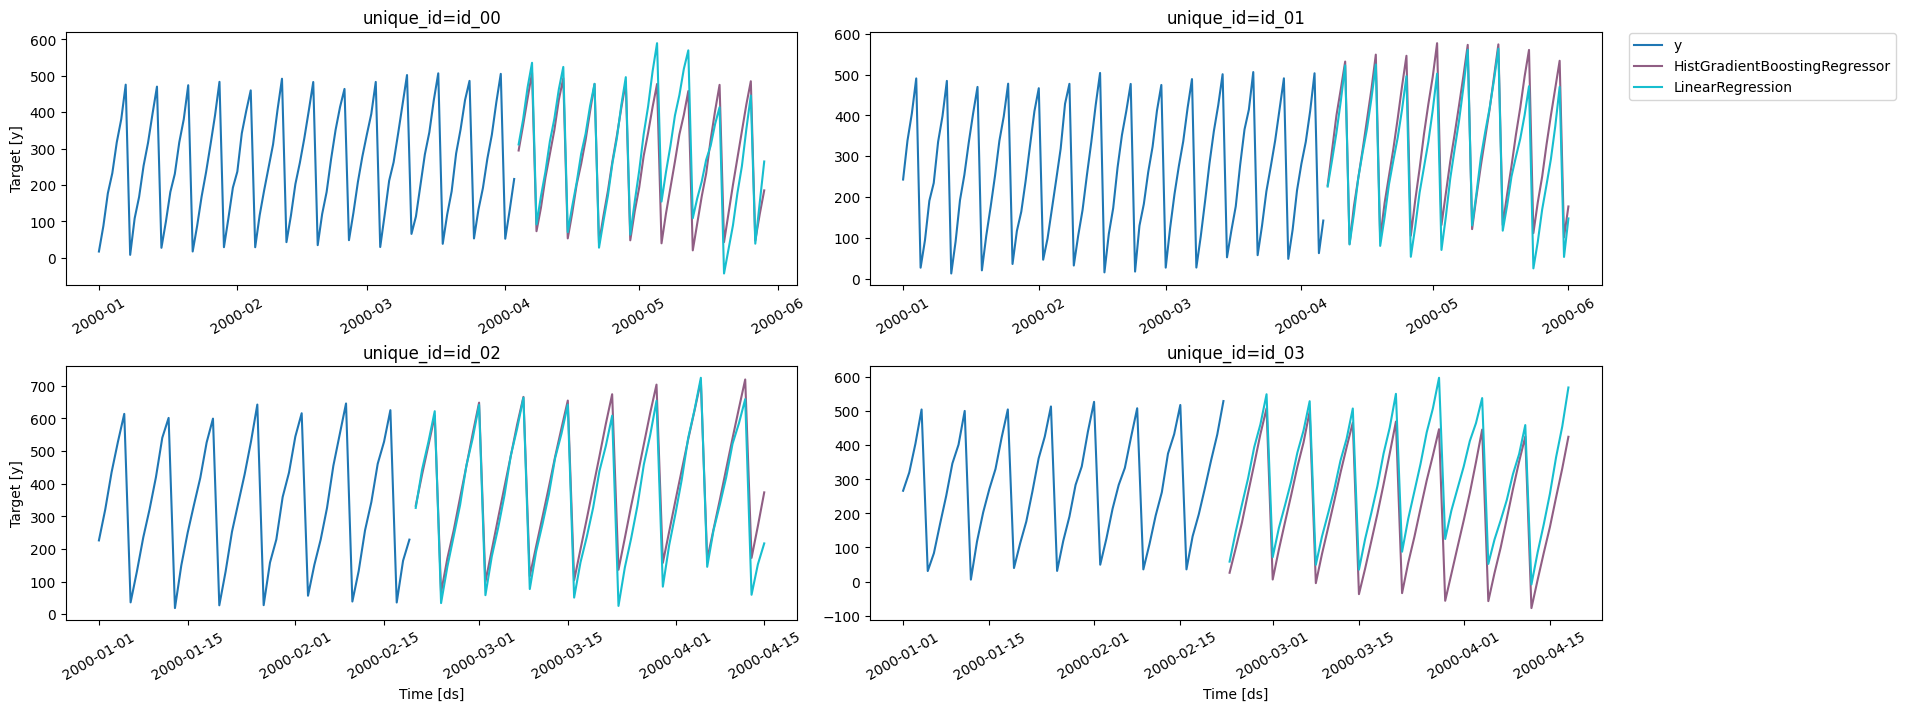

In [8]:
from utilsforecast.plotting import plot_series

fig = plot_series(series, predictions, max_ids=4, plot_random=False)
fig

Notice the difference in shape here.

## What about hyperparams?

In [9]:
import os
import tempfile

import optuna
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean
from sklearn.linear_model import Ridge

In [10]:
def my_init_config(trial: optuna.Trial):
    lag_transforms = [
        ExponentiallyWeightedMean(alpha=0.3),
        RollingMean(window_size=7, min_samples=1),
    ]
    lag_to_transform = trial.suggest_categorical('lag_to_transform', [7, 14])
    return {
        'lags': [i for i in range(1, 7)],  # this won't be tuned
        'lag_transforms': {lag_to_transform: lag_transforms},
    }

auto_mlf = AutoMLForecast(
    models=[AutoRidge()],
    freq="1D",
    season_length=24,
    init_config=my_init_config,
).fit(
    series,
    n_windows=2,
    h=5,
    num_samples=20,
)
preds = auto_mlf.predict(5)

/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/mlforecast/auto.py:278: UserWarning: `season_length` is not used when `init_config` is provided.
  warnings.warn("`season_length` is not used when `init_config` is provided.")
[I 2024-11-25 10:18:05,065] A new study created in memory with name: no-name-902f2ac3-22bf-4f4f-9567-c126b84e14f2
[I 2024-11-25 10:18:05,244] Trial 0 finished with value: 0.08552053007422931 and parameters: {'fit_intercept': False, 'alpha': 6.028030997340368, 'lag_to_transform': 7}. Best is trial 0 with value: 0.08552053007422931.
[I 2024-11-25 10:18:05,301] Trial 1 finished with value: 0.07667399700232899 and parameters: {'fit_intercept': True, 'alpha': 8.917838234820016, 'lag_to_transform': 7}. Best is trial 1 with value: 0.07667399700232899.
[I 2024-11-25 10:18:05,331] Trial 2 finished with value: 0.07667685637734895 and parameters: {'fit_intercept': True, 'alpha': 5.680877566378229, 'lag_to_transform': 7}. Best is trial 1 with value: 0.0766

In [11]:
auto_mlf.results_['AutoRidge'].best_params

{'fit_intercept': True, 'alpha': 9.89037013605113, 'lag_to_transform': 7}

## Use on an actual datasets 

Seoul subway data was retreived from [here](https://github.com/divakaivan/seoul_subway_data)

In [12]:
import polars as pl 
import polars.selectors as cs
import altair as alt

df = pl.concat([
    pl.read_parquet(f"seoul_subway_{year}.parquet") for year in [2014, 2015, 2016]
])

ml_df = (
    df
    .filter(pl.col("division") == "getting_off")
    .unpivot(cs.numeric(), index=["subway_station_code", "date"])
    .filter(pl.col("variable") != "subway_station_code")
    .with_columns(hour=pl.col("variable").str.head(2).cast(pl.Int8) - 1)
    .with_columns(ds=pl.col("date") + " " + pl.col("hour").cast(pl.String) + ":00:00")
    .select(pl.col("subway_station_code").cast(pl.String).alias("unique_id"), pl.col("ds").str.to_datetime(format="%Y-%m-%d %H:%M:%S"), pl.col("value").alias("y"))
    .sort("unique_id", "ds")
)

In [13]:
list(d["subway_station_code"] for d in df.select("subway_station_code").unique().to_dicts())[:10]

[2629, 310, 2513, 2516, 152, 2635, 426, 429, 423, 155]

In [14]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [15]:
import altair as alt

alt.Chart(ml_df.filter(pl.col("unique_id") == "411").head(1000)).mark_line().encode(x="ds", y="y").properties(width=1200).interactive()

alt.Chart(...)

In [16]:
subset = ml_df.filter(pl.col("ds") < pl.datetime(2016, 8, 30), pl.col("ds") > pl.datetime(2015, 6, 30))

(
    alt.Chart(subset.filter(pl.col("unique_id") == "150"))
        .mark_line()
        .encode(x="ds", y="y")
        .properties(width=1200)
        .interactive(bind_y=False)
)

alt.Chart(...)

In [17]:
cut_ml = ml_df.filter(pl.col("ds") < pl.datetime(2016, 8, 30), pl.col("ds") > pl.datetime(2015, 6, 30))

During the livestream we saw that we could get negative values from the `HistGradientBoostingRegressor`. 

In [34]:
from utilsforecast.preprocessing import fill_gaps

cut_ml = fill_gaps(cut_ml.to_pandas(), freq='h').fillna(0)

In [35]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklego.meta import DecayEstimator

def hour(dt): return dt.hour

pipe = make_pipeline(
    OneHotEncoder(), 
    Ridge()
)

fcst = MLForecast(
    models=[Ridge(), HistGradientBoostingRegressor()],
    freq='h',
    lags=[24, 24*7],
    # lag_transforms={
    #     24: [RollingMean(window_size=24)]
    # },
    date_features=['dayofweek', hour]
)

In [37]:
fcst.preprocess(cut_ml)

,unique_id,ds,y,lag24,lag168,dayofweek,hour
168,150,2015-07-07 04:00:00,323.0,458.0,326.0,1,4
169,150,2015-07-07 05:00:00,1654.0,2341.0,1532.0,1,5
170,150,2015-07-07 06:00:00,5048.0,5413.0,4827.0,1,6
171,150,2015-07-07 07:00:00,9905.0,9959.0,9730.0,1,7
172,150,2015-07-07 08:00:00,4753.0,4642.0,4448.0,1,8
...,...,...,...,...,...,...,...
2817095,434,2016-08-29 19:00:00,46.0,47.0,38.0,0,19
2817096,434,2016-08-29 20:00:00,35.0,26.0,45.0,0,20
2817097,434,2016-08-29 21:00:00,37.0,22.0,33.0,0,21
2817098,434,2016-08-29 22:00:00,14.0,12.0,27.0,0,22


In [38]:
fcst.fit(cut_ml)

MLForecast(models=[Ridge, HistGradientBoostingRegressor], freq=h, lag_features=['lag24', 'lag168'], date_features=['dayofweek', <function hour at 0x2b253d080>], num_threads=1)

In [39]:
fcst.predict(24)

,unique_id,ds,Ridge,HistGradientBoostingRegressor
0,150,2016-08-30 00:00:00,33.338303,2.753405
1,150,2016-08-30 01:00:00,33.753563,2.753405
2,150,2016-08-30 02:00:00,34.168823,2.753405
3,150,2016-08-30 03:00:00,34.584083,2.753405
4,150,2016-08-30 04:00:00,403.991477,390.926635
...,...,...,...,...
6595,434,2016-08-30 19:00:00,84.227964,44.214928
6596,434,2016-08-30 20:00:00,80.154472,44.214928
6597,434,2016-08-30 21:00:00,76.178534,39.534463
6598,434,2016-08-30 22:00:00,57.082847,18.752122


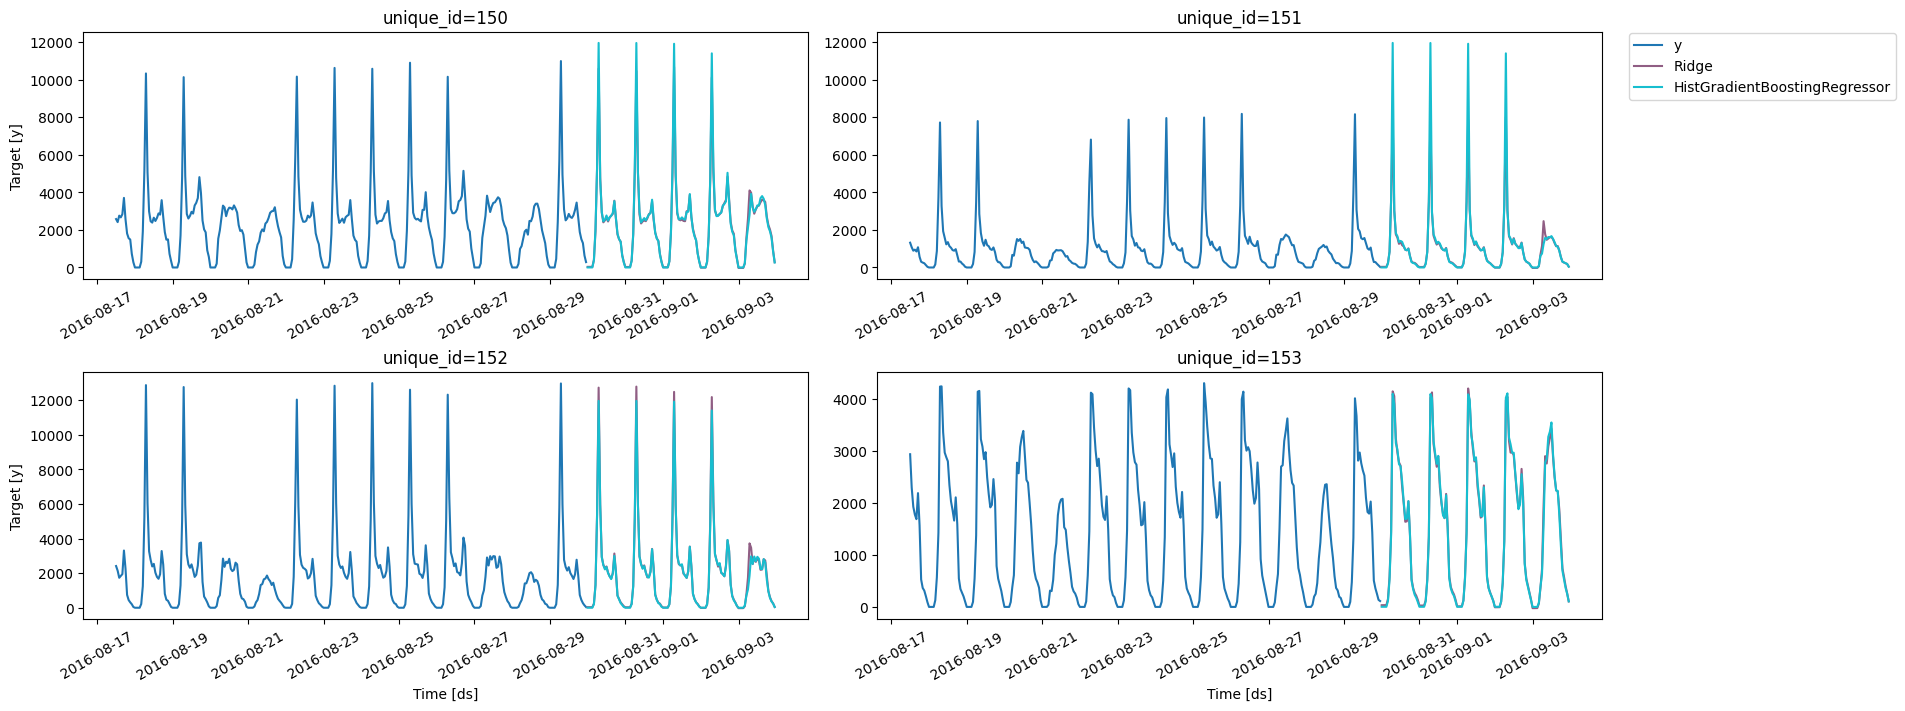

In [41]:
from utilsforecast.plotting import plot_series

predictions = fcst.predict(24*5)
fig = plot_series(cut_ml, predictions, max_ids=4, plot_random=False, max_insample_length=300)
fig

What is the issue here? 

It feels like there is a much easier pattern to learn. 

<Axes: >

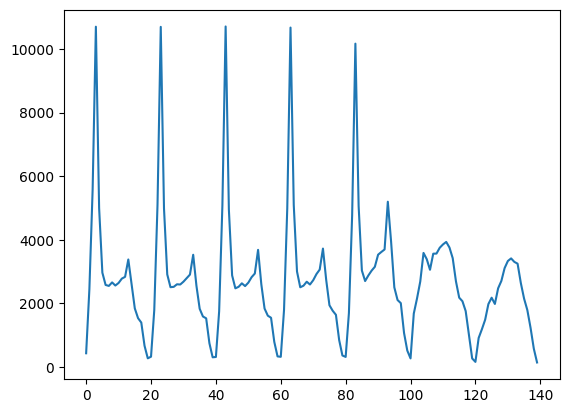

In [23]:
fcst.preprocess(cut_ml.filter(pl.col("unique_id")=="150").to_pandas()).groupby(["dayofweek", "hour"])[["y"]].median().reset_index()["y"].plot()

In [24]:
agg = fcst.preprocess(cut_ml.to_pandas()).groupby(["dayofweek", "hour"])[["y"]].median().reset_index()

fcst.preprocess(cut_ml.to_pandas()).drop(columns="y").merge(agg, how="left", on=["dayofweek", "hour"])

,unique_id,ds,lag24,lag168,dayofweek,hour,y
0,150,2015-07-08 12:00:00,4753.0,326.0,2,12,582.0
1,150,2015-07-08 13:00:00,2515.0,1532.0,2,13,570.0
2,150,2015-07-08 14:00:00,2410.0,4827.0,2,14,621.0
3,150,2015-07-08 15:00:00,2104.0,9730.0,2,15,712.0
4,150,2015-07-08 16:00:00,2261.0,4448.0,2,16,858.0
...,...,...,...,...,...,...,...
2302295,434,2016-08-29 19:00:00,48.0,29.0,0,19,702.5
2302296,434,2016-08-29 20:00:00,58.0,43.0,0,20,598.0
2302297,434,2016-08-29 21:00:00,68.0,30.0,0,21,569.0
2302298,434,2016-08-29 22:00:00,64.0,33.0,0,22,345.0


In [25]:
from sklearn.base import BaseEstimator, RegressorMixin

class GrouperModel(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.agg_ = X.assign(y=y).groupby(["dayofweek", "hour"]).mean()["y"]
        return self

    def predict(self, X):
        return X.merge(self.agg_, how="left", on=["dayofweek", "hour"]).fillna(0)["y"]

In [26]:
X = fcst.preprocess(cut_ml.to_pandas())[["dayofweek", "hour"]]
y = fcst.preprocess(cut_ml.to_pandas())["y"]

In [27]:
from skrub import SelectCols

def hour(dt): return dt.hour

pipe = make_pipeline(
    SelectCols(["hour", "dayofweek"]), 
    OneHotEncoder(handle_unknown="ignore"), 
    Ridge(fit_intercept=False), 
)

fcst = MLForecast(
    models=[GrouperModel(), pipe, HistGradientBoostingRegressor()],
    freq='h',
    date_features=['dayofweek', hour, 'month'],
    lags=[24, 24*7],
)

In [28]:
fcst.fit(cut_ml.to_pandas())

MLForecast(models=[GrouperModel, Ridge, HistGradientBoostingRegressor], freq=h, lag_features=['lag24', 'lag168'], date_features=['dayofweek', <function hour at 0x2db0ea660>, 'month'], num_threads=1)

In [29]:
predictions = fcst.predict(24*5)

In [69]:
cut_ml.min()

unique_id,ds,y
str,datetime[μs],i64
"""150""",2015-06-30 04:00:00,0


In [74]:
predictions["HistGradientBoostingRegressor"].min()

np.float64(-97.73914776049986)

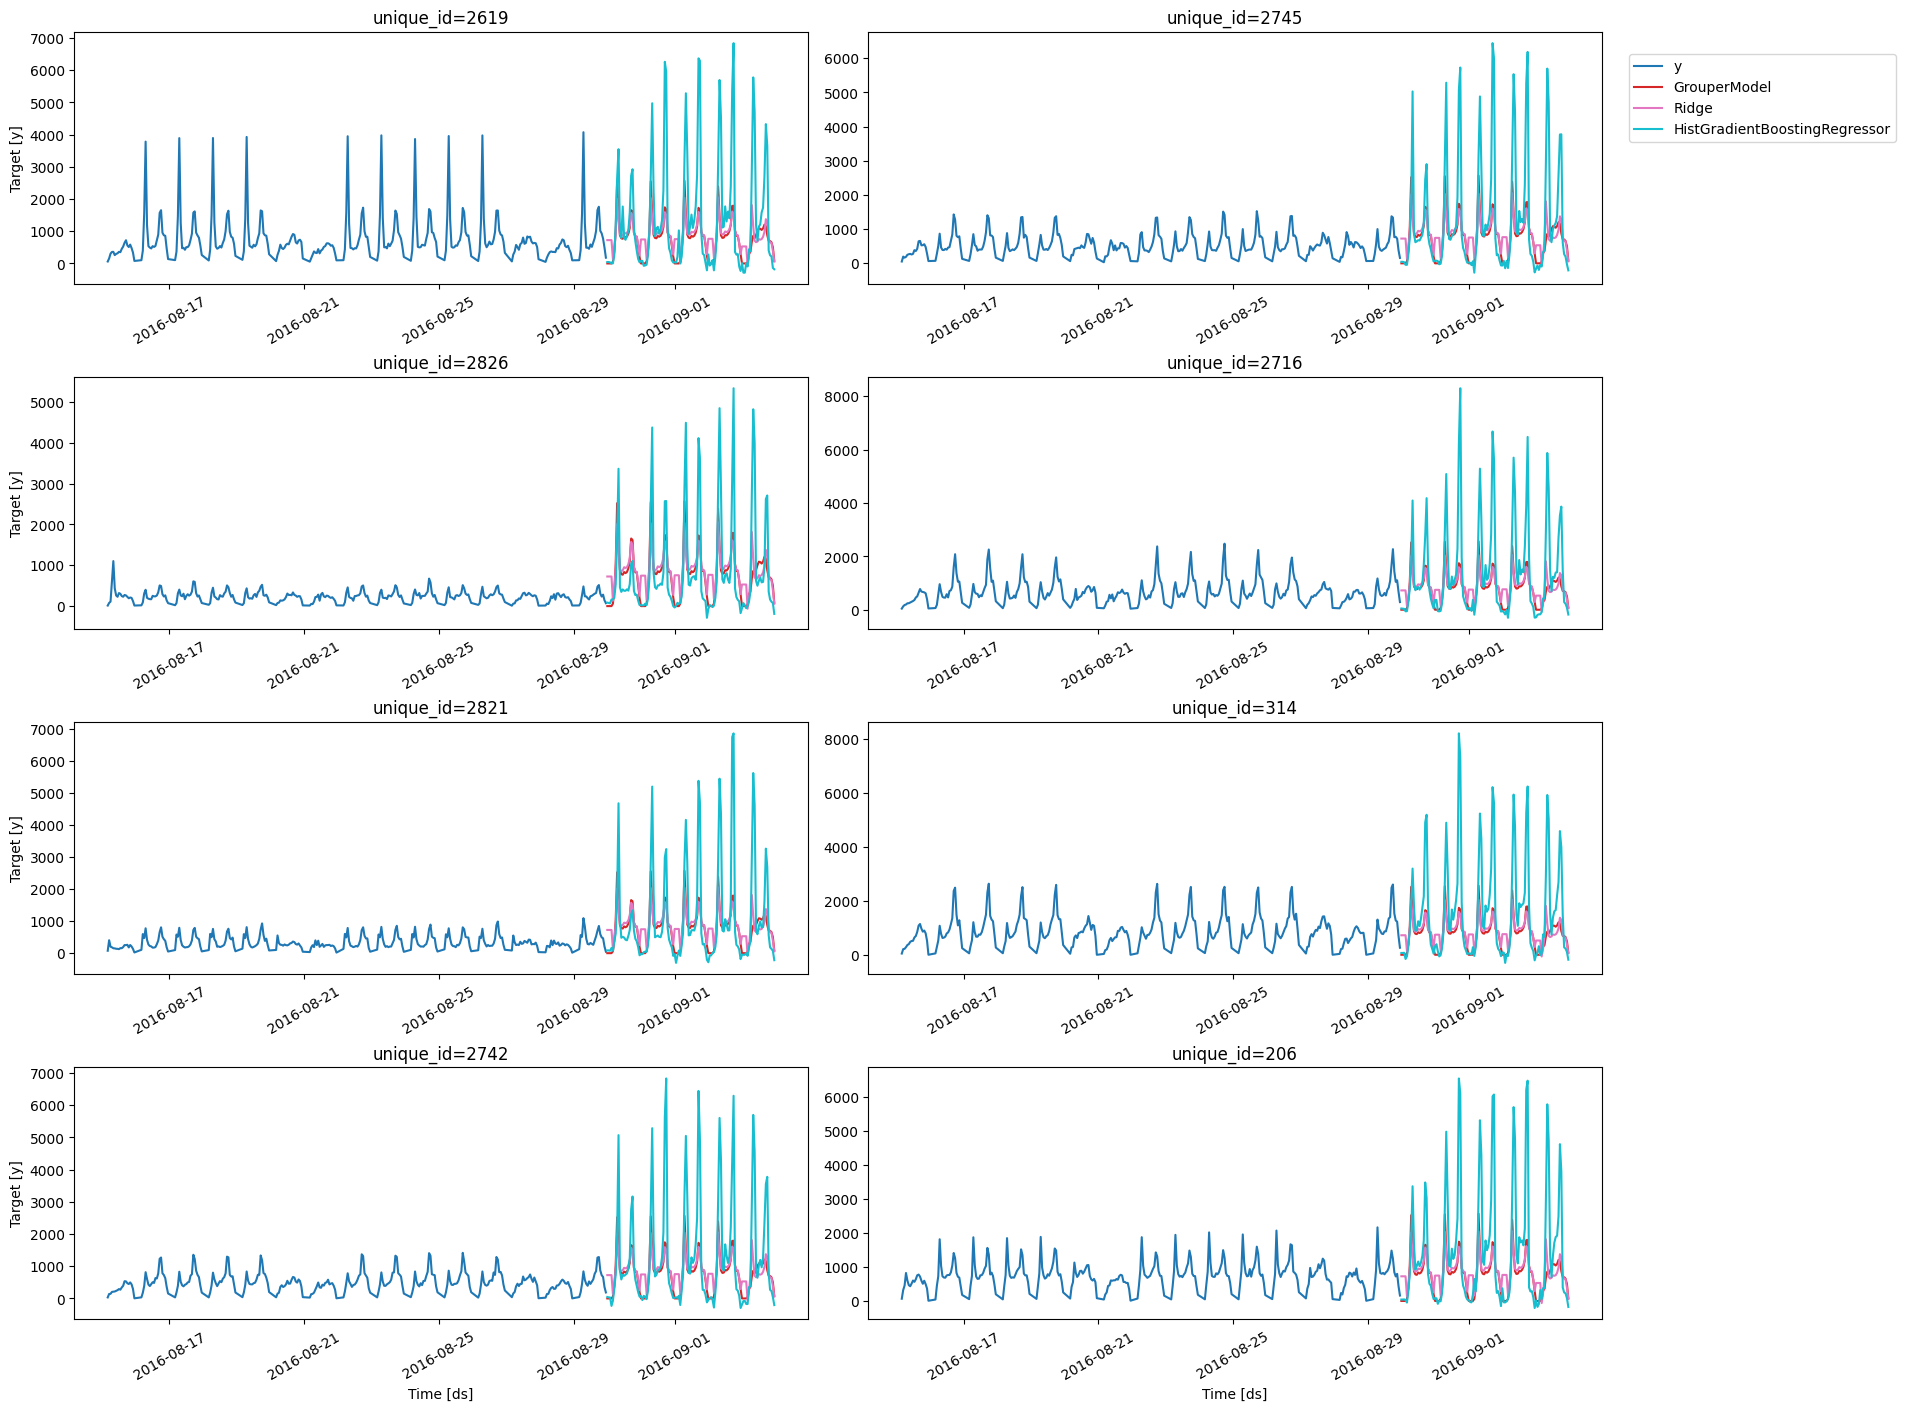

In [30]:
fig = plot_series(cut_ml.to_pandas(), predictions, max_ids=8, plot_random=True, max_insample_length=300)
fig

In [31]:
fcst.preprocess(cut_ml.to_pandas()).loc[lambda d: d["unique_id"] == "2826"]

,unique_id,ds,y,lag24,lag168,dayofweek,hour,month
1827728,2826,2015-07-08 12:00:00,237.0,257.0,17.0,2,12,7
1827729,2826,2015-07-08 13:00:00,245.0,197.0,57.0,2,13,7
1827730,2826,2015-07-08 14:00:00,304.0,163.0,353.0,2,14,7
1827731,2826,2015-07-08 15:00:00,356.0,144.0,443.0,2,15,7
1827732,2826,2015-07-08 16:00:00,339.0,230.0,263.0,2,16,7
...,...,...,...,...,...,...,...,...
1836095,2826,2016-08-29 19:00:00,307.0,220.0,132.0,0,19,8
1836096,2826,2016-08-29 20:00:00,234.0,272.0,286.0,0,20,8
1836097,2826,2016-08-29 21:00:00,280.0,289.0,323.0,0,21,8
1836098,2826,2016-08-29 22:00:00,142.0,220.0,238.0,0,22,8


In [32]:
alt.Chart(subset.filter(pl.col("unique_id") == "2826")).mark_line().encode(x="ds", y="y").properties(width=1200).interactive(bind_y=False)

alt.Chart(...)

In [33]:
cv_df = fcst.cross_validation(
    df=cut_ml.to_pandas(),
    h=24,
    n_windows=3,
)

In [34]:
cv_df

,unique_id,ds,cutoff,y,GrouperModel,Ridge,HistGradientBoostingRegressor
0,150,2016-08-27 04:00:00,2016-08-26 23:00:00,223,50.347305,-64.155121,26.594830
1,150,2016-08-27 05:00:00,2016-08-26 23:00:00,1584,296.993225,223.736123,436.385064
2,150,2016-08-27 06:00:00,2016-08-26 23:00:00,2166,358.047455,703.270588,1600.119299
3,150,2016-08-27 07:00:00,2016-08-26 23:00:00,2752,678.899597,1816.895667,1979.680330
4,150,2016-08-27 08:00:00,2016-08-26 23:00:00,3823,859.720215,1150.199521,6897.247179
...,...,...,...,...,...,...,...
16495,434,2016-08-29 19:00:00,2016-08-28 23:00:00,46,943.518005,928.651712,137.065882
16496,434,2016-08-29 20:00:00,2016-08-28 23:00:00,35,795.247253,827.385899,115.616315
16497,434,2016-08-29 21:00:00,2016-08-28 23:00:00,37,772.718262,809.461581,80.504913
16498,434,2016-08-29 22:00:00,2016-08-28 23:00:00,14,469.907318,559.616402,42.707891


In [35]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

evaluate(cv_df.drop(columns="cutoff"), metrics=[rmse], agg_fn='mean')

,metric,GrouperModel,Ridge,HistGradientBoostingRegressor
0,rmse,686.837734,755.893818,752.162494


In [52]:
# key = 'nixak-...'

In [37]:
from nixtla import NixtlaClient

client = NixtlaClient(api_key=key)

In [38]:
client.validate_api_key()

True

In [41]:
from utilsforecast.preprocessing import fill_gaps

fill_gaps(cut_ml.filter(pl.col("unique_id") == "2619").to_pandas(), freq='h').fillna(0).head(28)

,unique_id,ds,y
0,2619,2015-06-30 04:00:00,94.0
1,2619,2015-06-30 05:00:00,428.0
2,2619,2015-06-30 06:00:00,1456.0
3,2619,2015-06-30 07:00:00,3776.0
4,2619,2015-06-30 08:00:00,1357.0
5,2619,2015-06-30 09:00:00,453.0
6,2619,2015-06-30 10:00:00,491.0
7,2619,2015-06-30 11:00:00,484.0
8,2619,2015-06-30 12:00:00,562.0
9,2619,2015-06-30 13:00:00,524.0


In [46]:
timegpt_fcst_df = client.forecast(df=fill_gaps(cut_ml.filter(pl.col("unique_id") == "2619").to_pandas(), freq='h').fillna(0), h=24*7, freq='H', )
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/vincent/Development/probabl/.venv/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,TimeGPT
0,2619,2016-08-30 00:00:00,15.829069
1,2619,2016-08-30 01:00:00,-0.737835
2,2619,2016-08-30 02:00:00,20.163149
3,2619,2016-08-30 03:00:00,-30.138737
4,2619,2016-08-30 04:00:00,85.026150


<Axes: xlabel='ds'>

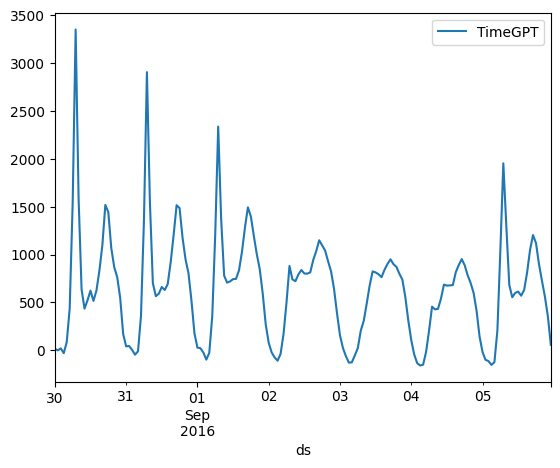

In [47]:
timegpt_fcst_df.plot("ds", "TimeGPT")

<Axes: xlabel='ds'>

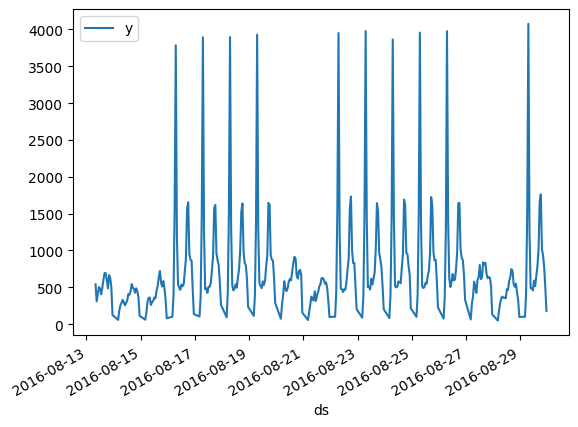

In [51]:
cut_ml.filter(pl.col("unique_id") == "2619").to_pandas().tail(24*14).plot("ds", "y")